In [4]:
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.sparse import linalg

import firedrake as fd
from firedrake import logging

import hydrogym as gym

fd.utils.ScalarType

dtype('float64')

In [5]:
flow = gym.flow.Cylinder(Re=50, mesh_name='coarse')
qB = flow.solve_steady()
solver = gym.ts.IPCS(flow, dt=1e-2)
A, B = solver.linearize(qB)  # Discrete time dynamics and control matrices

In [6]:
A.adjoint()

<13090x13090 _CustomLinearOperator with dtype=float64>

/home/firedrake/firedrake/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


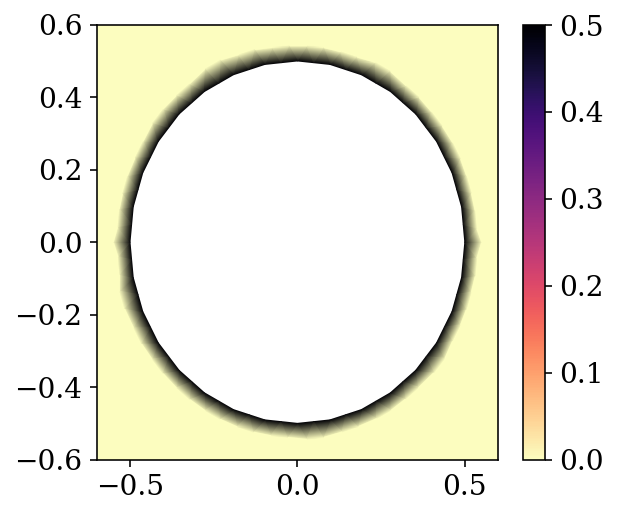

In [7]:
# Plot the control
B_fd = fd.Function(flow.mixed_space)
gym.utils.set_from_array(B_fd, B)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
Bu, Bp = B_fd.split()
im = fd.tripcolor(Bu, axes=ax, cmap='magma_r')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])
plt.colorbar(im)

In [8]:
%%time
evals, evecs = linalg.eigs(A, k=6, tol=1e-6)

CPU times: user 3min 5s, sys: 70.7 ms, total: 3min 6s
Wall time: 3min 5s


In [9]:
np.log(evals[0])/solver.dt

(0.023344063037580357-0.86149458870492j)

In [10]:
evec_fd = fd.Function(flow.mixed_space)
gym.utils.set_from_array(evec_fd, np.real(evecs[:, 0]))

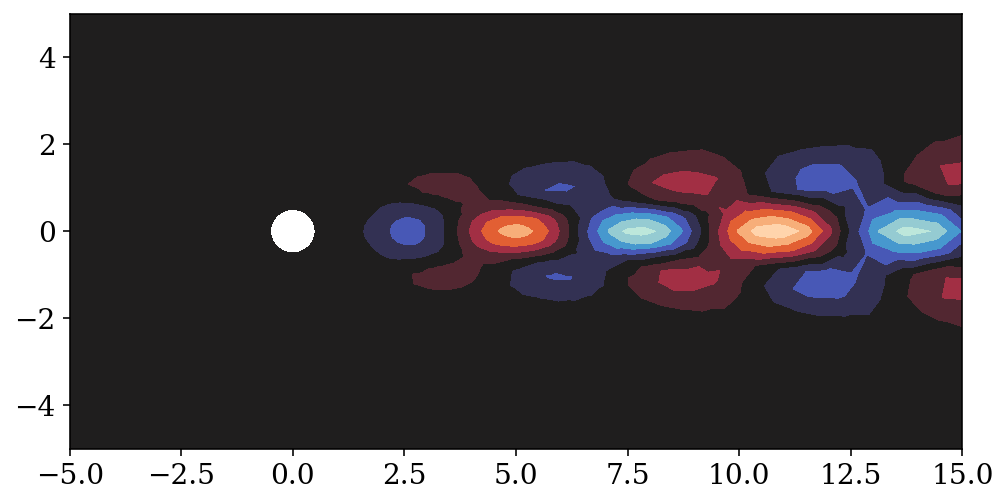

In [11]:
u1, p1 = evec_fd.split()
vort = fd.project(fd.curl(u1), flow.pressure_space)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.1, 0.1, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
plt.show()

### Adjoint stability

In [12]:
%%time
# logging.set_level(logging.WARNING)
evalsH, evecsH = linalg.eigs(A.adjoint(), k=6, tol=1e-6)

firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet been implemented correctly
firedrake:WARNING Adjoint time-stepping has not yet 

CPU times: user 11 s, sys: 340 ms, total: 11.4 s
Wall time: 12.5 s


In [13]:
np.log(evalsH[0])/solver.dt

(67.62513228717737+0j)

In [14]:
evalsH

array([1.96649215+0.j        , 1.16285042+0.j        ,
       1.04425565+0.j        , 1.02570494+0.j        ,
       1.01628864+0.02848811j, 1.01628864-0.02848811j])

In [15]:
evecH_fd = fd.Function(flow.mixed_space)
gym.utils.set_from_array(evecH_fd, np.real(evecsH[:, 0]))

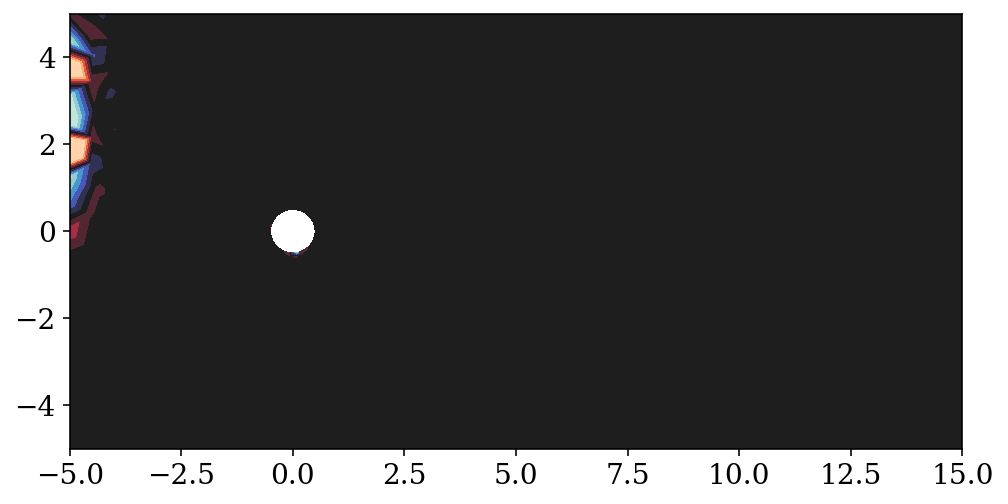

In [16]:
u1, p1 = evecH_fd.split()
vort = fd.project(fd.curl(u1), flow.pressure_space)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-0.02, 0.02, 10)
fd.tricontourf(vort, axes=ax, levels=levels, extend='both', 
               cmap=sns.color_palette("icefire", as_cmap=True))
plt.show()